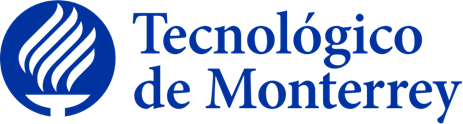

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries

In [1]:
from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
from peft import PeftModel
import json
from dotenv import load_dotenv
from datasets.arrow_dataset import Dataset
from deepeval.synthesizer import Synthesizer
from loader.legal_document_loader import LegalDocumentLoader
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.modeling_utils import PreTrainedModel
from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import shutil
import os
import re


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
demo_mode = False

### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [3]:
def extract_response(response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )
    
def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
    '''
    Generates the response from the model
    '''
    
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 650, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)
    
    return extract_response(result[0])

def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []
    if (isinstance(datapoints, Dataset)):
        datapoints = convert_from_hf_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        if (isinstance(golden,Golden)):
            datapoint = json.loads(golden.model_dump_json())
        
        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue
    
    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases 

def convert_from_hf_dataset_to_goldens(dataset: Dataset) -> list[Golden]:
    
    goldens = []
    for datapoint in dataset:
        if datapoint['context'] == None:
            continue
        golden = Golden(
            expectedOutput=datapoint['output'],
            input=datapoint['instruction'],
            context=[datapoint['context']],
        )
        
        goldens.append(golden)
        
    return goldens
        
        


### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [4]:
load_dotenv()

True

Now we proceed to download all the files

In [5]:
url = "https://github.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/raw/main/Avance-4/mexican_laws"

docs = LegalDocumentLoader.load_from_url(url)
path = './tmp'



We put all the files in a tmp directory and make sure that the filename is only in ascii characters

In [6]:
if not os.path.exists(path):
    os.makedirs(path)

for doc in docs:
    filename = doc['Title'].encode('ascii', 'ignore')
    filename = filename.decode()
    filename = filename.lower().replace(' ', '_') + '.txt'
    
    with open(os.path.join(path,filename), 'w') as f:
        f.write(doc['Text'])
    



Now we are ready for generating the dataset. For this, we'll use gpt-3.5-turbo since it's highly capable for this task and also cheaper. Please be aware that in order to run this code, it's necessary to provide an OpenAI API Key.

In [7]:

synth = Synthesizer( model = 'gpt-3.5-turbo', multithreading = False)

list_docs = []


for path, folders, files in os.walk('./tmp'):
    num_files = 2 if demo_mode else len(files)-1
    for file in files[:num_files]:
        if file.endswith('.txt'):
            list_docs.append(f'./tmp/{file}')

goldens = synth.generate_goldens_from_docs(
   
    document_paths=list_docs,
    include_expected_output=True,
    chunk_overlap=50,
    num_evolutions = 1,
    max_goldens_per_document=2 if demo_mode else 25)



Output()

num_contexts: 1
contexts:[['o contará a partir de la fecha del cambio.\n\nArtículo reformado DOF 31-12-2012\n\nArtículo 68.- Al 
término de los estudios en la Heroica Escuela Naval Militar, el personal de cadetes\n\nperteneciente a los Cuerpos 
será promovido al grado de Guardiamarina y el de los Servicios a Primer\nMaestre; los egresados de los demás 
establecimientos de educación naval de nivel licenciatura, al de\nPrimer Maestre, y los de nivel técnico 
profesional al de Segundo Maestre.\n\nArtículo reformado DOF 31-12-2012\n\nArtículo 69.- El personal de clases que 
concluya satisfactoriamente algún curso en los centros de\n\ncapacitación de la Armada de México, se sujetará a lo 
dispuesto en la Ley de Ascensos de la Armada de\nMéxico.\n\nArtículo reformado DOF 31-12-2012\n\nArtículo 70.- Se 
deroga.\n\nArtículo derogado DOF 31-12-2012\n\nCAPÍTULO QUINTO\nSITUACIONES DEL PERSONAL\n\nArtículo 71.- El 
personal de la Armada de México podrá encontrarse en alguna de las situaciones\n\nsiguientes:\n\nI. Activo;\n\nII. 
Reserva, o\n\nIII. Retiro.\n\nArtículo 72.- El personal se encuentra en servicio activo cuando está:\n\nI. 
Prestando sus servicios en unidades y establecimientos navales, ya sea como voluntario o de\n\nacuerdo con lo 
establecido en la Ley del Servicio Militar Nacional;\n\nII. A disposición;\n\nIII. En situación especial;\n\nIV. En
depósito, o\n\nV. Con licencia, a excepción de la ilimitada.\n\nFracción reformada DOF 31-12-2012\n\nArtículo 73.- 
Se encuentra a disposición:\n\nI. El personal en espera de órdenes para que le sea asignado cargo o comisión, 
y\n\nFracción reformada DOF 31-12-2012\n\nII. El personal que pase a esta situación por resolución de Órgano de 
Disciplina en los términos que\n\ndispone la Ley de Disciplina para el Personal de la Armada de México.\nFracción 
reformada DOF 31-12-2012\n\nIII. Se deroga.\n\nFracción derogada DOF 31-12-2012\n\nIV. Se deroga.\n\nFracción 
derogada DOF 31-12-2012\n\nArtículo 74.- El personal a que hace referencia la fracción II del artículo anterior, 
estará sujeto a las\n\nnormas siguientes:\n\nI. Mientras permanezca en esta situación, no será convocado para 
efectos de ascenso;\n\nII. Se le deducirá de la antigüedad del grado que ostente, el tiempo que dure a disposición 
y pasará a\n\nocupar el lugar que le corresponda del escalafón, y\n\nIII. El Alto Mando tendrá la facultad para 
suspender o dar por terminada la situación a disposición a\n\ntodo aquel personal que se encuentre considerado en 
la fracción II del artículo anterior.\nArtículo reformado DOF 31-12-2012\n\nArtículo 75.- Se encuentra en situación
especial:\n\nI. El que haya sido comisionado en otras dependencias e instituciones federales, estatales 
y\n\nmunicipales, y\n\nII. El que esté sujeto a proceso y el que, cumpliendo condena, no haya sido destituido por 
sentencia.\n\nArtículo 76.-', ' un tiempo equivalente a tres veces el que duren sus estudios.\n\nFracción reformada
DOF 31-12-2012\n\nEl personal que solicite su separación del servicio activo y no haya concluido con el tiempo de 
servicio\n\nespecificado en las fracciones anteriores, cubrirá el total o la parte proporcional del importe erogado
por\nla Institución para la realización de dichos estudios.\n\nPárrafo adicionado DOF 31-12-2012\n\nArtículo 53.- 
El personal seleccionado para efectuar cursos en establecimientos educativos de la\n\nArmada de México, deberá 
firmar un contrato en el que se establezca la obligación de servir en la misma\npor un término igual al de la 
duración de sus estudios.\n\nLa Armada de México expedirá el título profesional, diploma o constancia 
correspondiente a los\n\nnacionales o extranjeros que concluyan estudios en los establecimientos de educación 
naval, en los\ntérminos en que lo señalen las disposiciones aplicables.\n\nArtículo 54.- El personal desempeñará 
los cargos y comisiones acordes a su cuerpo, servicio y grado\n\nestablecidos en las planillas orgánicas de las 
unidades y establecimientos de la 

Let's save the generated goldens in a json file, so we don't have to generate the set again. For demonstration purposes, the generated dataset only contains a few goldens, since it would take too much time to generate a dataset of dozens testcases. The full test dataset is localted in 'synthetic data' directory.

In [8]:
synth.save_as(file_type='json', directory='./synthetic_data')

Synthetic goldens saved at ./synthetic_data/20240609_185721.json!


'./synthetic_data/20240609_185721.json'

We don't need the donwloaded files anymore, so we can delete them

In [9]:
shutil.rmtree(path)

### 3. Setting up the Finetuned Model

We proceed to download the main model, which was a quantized version of the Llama-3-8b. In order to run this code, it'necessary to have cuda device.

In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/qwen2-7b-instruct-bnb-4bit",
    max_seq_length = 32768,
    device_map='cuda:0',
    load_in_4bit = True,
)


==((====))==  Unsloth: Fast Qwen2 patching release 2024.6
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.151 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now we donwload the PEFT model containing the trained weights

In [7]:

model = PeftModel.from_pretrained(model, model_id='a01110946/unsloth-Qwen2-7b-Instruct-bnb-4bit-32k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2')
model.to('cuda:0')
FastLanguageModel.for_inference(model)

We define the prompt that we will provide to the Llama Model

In [8]:
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

In [9]:
from datasets import load_dataset

dataset = load_dataset("JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts")

### 4. Evaluating the Model

First, let's load the dataset containing all the goldens

In [13]:
with open('./synthetic_data/test_set.json', 'r') as f:
    test_set = json.load(f)
    
test_set[:2]

[{'input': '¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?',
  'actual_output': None,
  'expected_output': 'Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.',
  'context': ['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-12-2012\n\nXII. Otros que sean necesarios a juicio del Alto Mando.\n\nFracción adicionada DOF 31-12-2012\n\nArtículo 47.- Para ingresar a la Armada de México se requiere:\n\nI. Ser mexicano por nacimiento;\n\nII. No contar con otra nacionalidad;\n\nFracción reformada DOF 31-12-2012\n\nIII. Estar en pleno goce y ejercicio de los derech

Now, we create the test cases from the goldens. For the real evaluation we used 250+ testcases, For demonstration purposes, we will use only 10 testcases.

In [10]:
test_set = dataset['test']

In [11]:
len(test_set)

1120

In [13]:
test_cases = generate_test_cases(model, tokenizer, test_set, alpaca_based_prompt)
test_cases[:5]

Generating test cases:   0%|          | 0/1107 [00:00<?, ?it/s]

Generating test cases: 100%|██████████| 1107/1107 [1:14:57<00:00,  4.06s/it]


[LLMTestCase(input='¿Qué información debe enviar el Banco de México al Ejecutivo Federal y al Congreso de la Unión según el Artículo 51 de la Ley del Banco de México?', actual_output='Según el Artículo 51 de la Ley del Banco de México, el Banco de México debe enviar al Ejecutivo Federal y al Congreso de la Unión un informe anualmente que incluya información sobre las actividades del Banco, el estado de sus cuentas, los resultados del ejercicio económico y las proyecciones financieras para el futuro.<|im_end|>', expected_output='El Banco de México debe enviar al Ejecutivo Federal y al Congreso de la Unión una exposición sobre la política monetaria a seguir por la Institución en el ejercicio respectivo en enero de cada año, así como un informe sobre el presupuesto de gasto corriente e inversión física de la Institución correspondiente a dicho ejercicio. Además, a más tardar cuarenta y cinco días hábiles después del cierre de cada trimestre, debe enviar un informe sobre la inflación, la e

Sometimes the Llama model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [14]:
test_cases = exclude_test_cases_with_empty_outputs(test_cases)

A total of 17 testcases were removed from the set


In [15]:
dataset = EvaluationDataset(test_cases)

In [20]:
from deepeval.dataset.utils import convert_test_cases_to_goldens

goldens = convert_test_cases_to_goldens(test_cases)

In [22]:
backup_dataset = EvaluationDataset(goldens = goldens)
backup_dataset.save_as('json', './test_cases')

Evaluation dataset saved at ./test_cases/20240614_032610.json!


'./test_cases/20240614_032610.json'

In [19]:
dataset.goldens

[]

In [18]:
dataset.save_as('json', './test_cases')

ValueError: No synthetic goldens found. Please generate goldens before attempting to save data as json

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [23]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

No we get the results from the evaluation

In [ ]:
results = evaluate(dataset, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

Now we print the scores:

In [25]:
scores = aggregate_metric_pass_rates(results)

if not demo_mode:
    with open('./test_results/test_results.json', 'w') as f:
        json.dump(scores, f)



Overall Metric Pass Rates

HallucinationMetric: 35.23% pass rate
AnswerRelevancyMetric: 61.65% pass rate
GEval: 75.41% pass rate




In case the notebook is in demo mode, we load the real scores and print them out:

In [21]:
if demo_mode:
    with open('./test_results/test_results.json') as f:
        scores = json.load(f)
        
    print("\n" + "=" * 70 + "\n")
    print("Overall Metric Pass Rates\n")
    for metric, pass_rate in scores.items():
        print(f"{metric}: {pass_rate:.2%} pass rate")
    print("\n" + "=" * 70 + "\n")




Overall Metric Pass Rates

HallucinationMetric: 4.03% pass rate
AnswerRelevancyMetric: 92.62% pass rate
GEval: 89.93% pass rate




### 5. Conclusions

The model has a good performance on the GEval and Answer Relevancy metrics (92.62% and 89.93$ respectively). Nonetheless, the hallucination metric is not satisfactory (4.03%) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

Because the model has low score in the hallucination metric, it's still not ready for production.